# 라이브러리 불러오기

In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import re

# 한글 폰트 설정
import matplotlib.font_manager as fm

font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)


# 경고 문구 미표
import warnings
warnings.filterwarnings('ignore')

# YouTubeSearchTool 
- 유튜브 검색해서 URL 목록을 제공하는 도구
- 검색어: 키워드,개수

In [59]:
from langchain_community.tools import YouTubeSearchTool #langchain 지원 유튜브 서치 툴

tool = YouTubeSearchTool()

In [6]:
results = tool.run("챔피언스리그 조추첨,10") #run명령어(검색어, 갯수)

In [8]:
# 문자열을 파이썬 리스트로 변환
import json
url_list = json.loads(results.replace("'", '"'))

# 결과 출력
print(url_list)

['https://www.youtube.com/watch?v=2tg57Svu3UU&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D', 'https://www.youtube.com/watch?v=W5nsgsDp4OA&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D', 'https://www.youtube.com/watch?v=Y_wxdpVOEY4&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D', 'https://www.youtube.com/watch?v=3skPPkwD9No&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D', 'https://www.youtube.com/watch?v=Ocvr_8aXQZU&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D', 'https://www.youtube.com/watch?v=QBaCqcbaoxY&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D', 'https://www.youtube.com/watch?v=87knwYLuHYM&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D', 'https://www.youtube.com/watch?v=VVCpJFtaAHg&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D', 'https://www.youtube.com/watch?v=6jO7GFYWz3Y&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D', 'https://www.youtube.com/watch?v=JXXf5gCDAiE&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D']


In [9]:
len(url_list)

10

In [10]:
url_list[0]

'https://www.youtube.com/watch?v=2tg57Svu3UU&pp=ygUc7LGU7ZS87Ja47Iqk66as6re4IOyhsOy2lOyyqA%3D%3D'

In [12]:
# 함수로 정의
def search_youtube(keyword, max_results=20):
    """
    유튜브에서 키워드 검색 결과를 가져오는 함수
    Args:
        keyword: 검색할 키워드
        max_results: 가져올 최대 결과 수
    Returns:
        url_list: 검색 결과의 URL 리스트
    """
    tool = YouTubeSearchTool()
    results = tool.run(f"{keyword},{max_results}")
    url_list = json.loads(results.replace("'", '"'))
    return url_list


# 함수 실행
url_list = search_youtube("챔피언스리그 조추첨")
len(url_list)

20

In [13]:
url_list2 = search_youtube("챔피언스리그 조추첨")
len(url_list2)

20

In [14]:
len(set(url_list) - set(url_list2)) # 유튜브 검색 결과가 매번 바뀜

10

# YoutubeLoader
- url을 입력하면 유튜브 자막을 추출하여 문서 객체로 변환
- add_video_info: 비디오 정보를 추가

In [15]:
from langchain_community.document_loaders import YoutubeLoader
# langchain에서 자막을 추출하는 기능 지원
# 자막을 포함한 동영상 정보를 가져오기
loader = YoutubeLoader.from_youtube_url(
    url_list[0], 
    add_video_info=True,
    language=["ko", "en"],
    translation="ko",
)

docs = loader.load()
print(len(docs))
print(docs[0])
print(docs[0].metadata)

1
page_content='이번 시즌부터 챔스 대회 운영 방식이 개편되면서 기존 32개 클럽에서 36개의 클럽으로 확대되었고 이웃 더욱 재미있어질 거라고 예상되는 24 25 시즌 챔스 조추첨 결과에 대해 알아보자 포트 1 잉글랜드 프리미어 리그 맨체스터 시티 독일 군대스리가 바이에르 미는 스페인라리가 레알 마드리드 프랑스 리가 파리생제르만 잉글랜드 프리미어 리그 리버풀 이탈리아 세리의 인터밀란 독일 분데스리가 도르트문트 독일 분데스리가 라이프비 스페 라리가 바르셀로나 포트 독일 분데스리가 바이언 공사 레보 데드 스테라 리가 아틀레티코 마드리드 이탈리아 세리의 a 아틀란다 이탈리아 세리의 a 유벤투스 포르투갈 프리메이라리가 벤피카 잉글랜드 프리미어 리그 아스날 벨기에 프리그 클럽 프레 우크라이나 프리미어 리그 샤타 도네츠 이탈리아 세리의 a 밀란 포트 3 네덜란드에 레디 BC 페에 노르드 포르투가 프리메이라리가 스포르팅 리스본 네덜란드 ldbc psv 인벤 크로아티아 프로리그 디나모 자그레브 오스트리아 스리가 즈루 프랑스 리그 앙리 세르비아 수리가 츠르베나 즈베즈다 스위스 슈퍼리그 영보이즈 스코트랜드 프리미어리그 셀틱 포트 4 슬로바키아 스리가 슬로반 브라티슬라바 프랑스리그 AS 모나고 체스카 포트발 로바 리가 스파르타 프라 잉글랜드 프리미어리그 아스톤빌라 이탈리아 세리의 a 볼로나 스페인라리가 지로나 독일 분데스리가 슈트가르트 오스트리아 분데스리가 슈트 그라스 프랑스 리그 스타드 브레스 이렇게 챔피언스 리그 조추 처음 결과 각 팀별 포트 1 포트 2 포트 3 포트 4 경기가 확정이 되면서 과연 36개의 클럽 중 16강으로 올라가게 돼 자신의 체해 클럽은 어디인가요' metadata={'source': '2tg57Svu3UU', 'title': '챔피언스리그 진출 클럽!! 레전드 빅 매치 탄생!!', 'description': 'Unknown', 'view_count': 3479, 'thumbnail_url': 'https://i.ytimg.com/vi/2tg

In [16]:
# 함수를 정의
def get_youtube_video_transcript(url):
    """
    YouTube 동영상의 자막을 가져오는 함수
    Args:
        url (str): YouTube 동영상 URL
    Returns:
        Document: 동영상 자막 정보 객체
    """
    loader = YoutubeLoader.from_youtube_url(
        url,
        add_video_info=True,
        language=["ko", "en"],
        translation="ko",
    )

    docs = loader.load()
    return docs

# 함수 실행
docs = get_youtube_video_transcript(url_list[0])
print(len(docs))
print(docs[0])

1
page_content='이번 시즌부터 챔스 대회 운영 방식이 개편되면서 기존 32개 클럽에서 36개의 클럽으로 확대되었고 이웃 더욱 재미있어질 거라고 예상되는 24 25 시즌 챔스 조추첨 결과에 대해 알아보자 포트 1 잉글랜드 프리미어 리그 맨체스터 시티 독일 군대스리가 바이에르 미는 스페인라리가 레알 마드리드 프랑스 리가 파리생제르만 잉글랜드 프리미어 리그 리버풀 이탈리아 세리의 인터밀란 독일 분데스리가 도르트문트 독일 분데스리가 라이프비 스페 라리가 바르셀로나 포트 독일 분데스리가 바이언 공사 레보 데드 스테라 리가 아틀레티코 마드리드 이탈리아 세리의 a 아틀란다 이탈리아 세리의 a 유벤투스 포르투갈 프리메이라리가 벤피카 잉글랜드 프리미어 리그 아스날 벨기에 프리그 클럽 프레 우크라이나 프리미어 리그 샤타 도네츠 이탈리아 세리의 a 밀란 포트 3 네덜란드에 레디 BC 페에 노르드 포르투가 프리메이라리가 스포르팅 리스본 네덜란드 ldbc psv 인벤 크로아티아 프로리그 디나모 자그레브 오스트리아 스리가 즈루 프랑스 리그 앙리 세르비아 수리가 츠르베나 즈베즈다 스위스 슈퍼리그 영보이즈 스코트랜드 프리미어리그 셀틱 포트 4 슬로바키아 스리가 슬로반 브라티슬라바 프랑스리그 AS 모나고 체스카 포트발 로바 리가 스파르타 프라 잉글랜드 프리미어리그 아스톤빌라 이탈리아 세리의 a 볼로나 스페인라리가 지로나 독일 분데스리가 슈트가르트 오스트리아 분데스리가 슈트 그라스 프랑스 리그 스타드 브레스 이렇게 챔피언스 리그 조추 처음 결과 각 팀별 포트 1 포트 2 포트 3 포트 4 경기가 확정이 되면서 과연 36개의 클럽 중 16강으로 올라가게 돼 자신의 체해 클럽은 어디인가요' metadata={'source': '2tg57Svu3UU', 'title': '챔피언스리그 진출 클럽!! 레전드 빅 매치 탄생!!', 'description': 'Unknown', 'view_count': 3692, 'thumbnail_url': 'https://i.ytimg.com/vi/2tg

# create_extraction_chain 활용하여 요약, 추출

In [65]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [18]:
docs[0]

Document(page_content='이번 시즌부터 챔스 대회 운영 방식이 개편되면서 기존 32개 클럽에서 36개의 클럽으로 확대되었고 이웃 더욱 재미있어질 거라고 예상되는 24 25 시즌 챔스 조추첨 결과에 대해 알아보자 포트 1 잉글랜드 프리미어 리그 맨체스터 시티 독일 군대스리가 바이에르 미는 스페인라리가 레알 마드리드 프랑스 리가 파리생제르만 잉글랜드 프리미어 리그 리버풀 이탈리아 세리의 인터밀란 독일 분데스리가 도르트문트 독일 분데스리가 라이프비 스페 라리가 바르셀로나 포트 독일 분데스리가 바이언 공사 레보 데드 스테라 리가 아틀레티코 마드리드 이탈리아 세리의 a 아틀란다 이탈리아 세리의 a 유벤투스 포르투갈 프리메이라리가 벤피카 잉글랜드 프리미어 리그 아스날 벨기에 프리그 클럽 프레 우크라이나 프리미어 리그 샤타 도네츠 이탈리아 세리의 a 밀란 포트 3 네덜란드에 레디 BC 페에 노르드 포르투가 프리메이라리가 스포르팅 리스본 네덜란드 ldbc psv 인벤 크로아티아 프로리그 디나모 자그레브 오스트리아 스리가 즈루 프랑스 리그 앙리 세르비아 수리가 츠르베나 즈베즈다 스위스 슈퍼리그 영보이즈 스코트랜드 프리미어리그 셀틱 포트 4 슬로바키아 스리가 슬로반 브라티슬라바 프랑스리그 AS 모나고 체스카 포트발 로바 리가 스파르타 프라 잉글랜드 프리미어리그 아스톤빌라 이탈리아 세리의 a 볼로나 스페인라리가 지로나 독일 분데스리가 슈트가르트 오스트리아 분데스리가 슈트 그라스 프랑스 리그 스타드 브레스 이렇게 챔피언스 리그 조추 처음 결과 각 팀별 포트 1 포트 2 포트 3 포트 4 경기가 확정이 되면서 과연 36개의 클럽 중 16강으로 올라가게 돼 자신의 체해 클럽은 어디인가요', metadata={'source': '2tg57Svu3UU', 'title': '챔피언스리그 진출 클럽!! 레전드 빅 매치 탄생!!', 'description': 'Unknown', 'view_count': 3692, 'thumbnail_url': 'https://i.ytimg.co

In [21]:
from langchain.chains import create_extraction_chain
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# 스키마 정의
schema = {
    "properties": {
        "팀_이름": {"type": "string"},
        "소속_리그": {"type": "string"},
        "포트_번호": {"type": "string"},
        "상대팀_목록": {"type": "string"},
    },
    "required": ["팀_이름", "소속_리그", "포트_번호", "상대팀_목록"],
}


# Chain 생성
prompt_template = """Extract and save the relevant entities mentioned \
in the following passage together with their properties. 
Only extract the properties mentioned in the 'information_extraction' function. \
When no suitable data is present, show the default value 'N/A'.

Passage:
{input}
""" 

prompt = ChatPromptTemplate.from_template(prompt_template)
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125", api_key=OPENAI_API_KEY)
chain = create_extraction_chain(schema=schema, llm=llm, prompt=prompt)

# Chain 실행
response = chain.invoke(docs[0])

# 결과 확인
response

{'input': Document(page_content='이번 시즌부터 챔스 대회 운영 방식이 개편되면서 기존 32개 클럽에서 36개의 클럽으로 확대되었고 이웃 더욱 재미있어질 거라고 예상되는 24 25 시즌 챔스 조추첨 결과에 대해 알아보자 포트 1 잉글랜드 프리미어 리그 맨체스터 시티 독일 군대스리가 바이에르 미는 스페인라리가 레알 마드리드 프랑스 리가 파리생제르만 잉글랜드 프리미어 리그 리버풀 이탈리아 세리의 인터밀란 독일 분데스리가 도르트문트 독일 분데스리가 라이프비 스페 라리가 바르셀로나 포트 독일 분데스리가 바이언 공사 레보 데드 스테라 리가 아틀레티코 마드리드 이탈리아 세리의 a 아틀란다 이탈리아 세리의 a 유벤투스 포르투갈 프리메이라리가 벤피카 잉글랜드 프리미어 리그 아스날 벨기에 프리그 클럽 프레 우크라이나 프리미어 리그 샤타 도네츠 이탈리아 세리의 a 밀란 포트 3 네덜란드에 레디 BC 페에 노르드 포르투가 프리메이라리가 스포르팅 리스본 네덜란드 ldbc psv 인벤 크로아티아 프로리그 디나모 자그레브 오스트리아 스리가 즈루 프랑스 리그 앙리 세르비아 수리가 츠르베나 즈베즈다 스위스 슈퍼리그 영보이즈 스코트랜드 프리미어리그 셀틱 포트 4 슬로바키아 스리가 슬로반 브라티슬라바 프랑스리그 AS 모나고 체스카 포트발 로바 리가 스파르타 프라 잉글랜드 프리미어리그 아스톤빌라 이탈리아 세리의 a 볼로나 스페인라리가 지로나 독일 분데스리가 슈트가르트 오스트리아 분데스리가 슈트 그라스 프랑스 리그 스타드 브레스 이렇게 챔피언스 리그 조추 처음 결과 각 팀별 포트 1 포트 2 포트 3 포트 4 경기가 확정이 되면서 과연 36개의 클럽 중 16강으로 올라가게 돼 자신의 체해 클럽은 어디인가요', metadata={'source': '2tg57Svu3UU', 'title': '챔피언스리그 진출 클럽!! 레전드 빅 매치 탄생!!', 'description': 'Unknown', 'view_count': 3692, 'thumbnail_url': 'https://

In [22]:
# 결과를 판다스 데이터프레임으로 변환
df = pd.DataFrame(response['text'])
df.head()

,팀_이름,소속_리그,포트_번호,상대팀_목록
0,맨체스터 시티,잉글랜드 프리미어 리그,포트 1,"도르트문트, 레알 마드리드, 파리생제르만"
1,리버풀,잉글랜드 프리미어 리그,포트 1,"도르트문트, 레알 마드리드, 파리생제르만"
2,인터밀란,이탈리아 세리의,포트 1,"도르트문트, 레알 마드리드, 파리생제르만"
3,바이에른 미는,독일 군대스리가,포트 1,"도르트문트, 레알 마드리드, 파리생제르만"
4,바르셀로나,스페인라리가,포트 2,"PSV, 스포르팅 리스본, 벤피카"


In [25]:
# 전체 동영상에 대해 자막을 추출하고 엔티티를 추출
def extract_entities_from_youtube_videos(url_list):
    """
    YouTube 동영상의 자막을 가져와 엔티티를 추출하는 함수
    Args:
        url_list (list): YouTube 동영상 URL 리스트
    Returns:
        pd.DataFrame: 엔티티 추출 결과
    """
    # 스키마 정의
    schema = {
        "properties": {
            "팀_이름": {"type": "string"},
            "소속_리그": {"type": "string"},
            "포트_번호": {"type": "string"},
            "상대팀_목록": {"type": "string"},
        },
    "required": ["팀_이름", "소속_리그", "포트_번호", "상대팀_목록"],
}


    # Chain 생성
    prompt_template = """Extract and save the relevant entities mentioned \
    in the following passage together with their properties. 
    Only extract the properties mentioned in the 'information_extraction' function. \
    When no suitable data is present, show the default value 'N/A'.

    Passage:
    {input}
    """ 

    prompt = ChatPromptTemplate.from_template(prompt_template)
    llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-0125", api_key=OPENAI_API_KEY)
    chain = create_extraction_chain(schema=schema, llm=llm, prompt=prompt)

    # 결과를 저장할 데이터프레임 생성
    df = pd.DataFrame()

    for url in url_list:
        # 동영상 자막 가져오기
        docs = get_youtube_video_transcript(url)

        # Chain 실행
        response = chain.invoke(docs[0])

        # 결과를 데이터프레임으로 변환
        df = pd.concat([df, pd.DataFrame(response['text'])])

    return df

In [26]:
df = extract_entities_from_youtube_videos(url_list[:2])
df

,팀_이름,소속_리그,포트_번호,상대팀_목록
0,맨체스터 시티,잉글랜드 프리미어 리그,포트 1,"도르트문트, 라이프비, 바이언 공사, 레보 데드"
1,레알 마드리드,스페인 라리가,포트 1,"파리생제르만, 바르셀로나, 아틀레티코 마드리드"
2,인터밀란,이탈리아 세리의,포트 1,"밀란, 유벤투스, 볼로나"
3,벤피카,포르투갈 프리메이라리가,포트 2,"아스날, 샤타 도네츠, 스포르팅 리스본"
4,PSV 인벤,네덜란드 ldbc,포트 3,"레디 BC, 프레 우크라이나, 디나모 자그레브"
5,AS 모나고,프랑스리그,포트 4,"AS 모나고, 스파르타 프라, 아스톤빌라"
0,토트넘,N/A,N/A,N/A
1,아약스,N/A,N/A,N/A
2,페르트,N/A,N/A,N/A
3,바이에른 뮌헨,N/A,N/A,N/A


# 유튜브 동영상 댓글 분석
삼성 SDS 채널 구독 이벤트   
https://www.youtube.com/watch?v=j_EciRV3V1k&t=15s

## 댓글 데이터 크롤링으로 수집

In [5]:
# 삼성 SDS 채널 구독 이벤트 

url = "https://www.youtube.com/watch?v=j_EciRV3V1k&t=15s"

In [11]:
# Seleium 드라이버 생성
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

from bs4 import BeautifulSoup
import time
import random

# Chrome 옵션 설정
options = webdriver.ChromeOptions()
# options.add_argument('--headless')  

# 드라이버 서비스 생성
service = Service()

# 웹 드라이버 초기화
driver = webdriver.Chrome(service=service, options=options)

# 윈도우 크기 설정
driver.set_window_size(800, 600)

# URL 접속하여 실행
driver.implicitly_wait(5)
driver.get(url)

# 팝업의 '아니요' 버튼을 클릭하여 닫기
try:
    dismiss_button = driver.find_element(By.CSS_SELECTOR, "#dismiss-button button")
    dismiss_button.click()
except:
    pass 

In [12]:
# 현재 페이지 높이
current_page_height = driver.execute_script("return document.documentElement.scrollHeight") 
print(current_page_height)


# 스크롤 다운
while current_page_height < 100000: 
    
    driver.execute_script(f"window.scrollTo({current_page_height}, {current_page_height + 10000});") 
    time.sleep(random.randint(1, 4))
    body = driver.find_element(By.CSS_SELECTOR, 'body')
    body.send_keys(Keys.PAGE_DOWN)
    time.sleep(random.randint(1, 4))
    
    scrolled_page_height = driver.execute_script("return document.documentElement.scrollHeight")  
    if scrolled_page_height == current_page_height: 
        break
    current_page_height = driver.execute_script("return document.documentElement.scrollHeight")     


2858


In [13]:
# HTML 소스 파싱 
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')
soup.find(name="div", attrs={"id":"contents"})

# 댓글 요소를 찾기
reviews = soup.find_all(name='ytd-comment-thread-renderer', attrs={'class':'style-scope ytd-item-section-renderer'})

print(len(reviews))
print(reviews[2])

445
<ytd-comment-thread-renderer class="style-scope ytd-item-section-renderer"><!--css-build:shady--><!--css-build:shady--><dom-if class="style-scope ytd-comment-thread-renderer"><template is="dom-if"></template></dom-if>
<ytd-comment-view-model class="style-scope ytd-comment-thread-renderer" id="comment" style="--ytd-comment-paid-background-color: initial;"><!--css-build:shady--><!--css-build:shady--><div class="style-scope ytd-comment-view-model" id="paid-comment-background"></div>
<div class="style-scope ytd-comment-view-model" id="linked-comment-badge"></div>
<div class="style-scope ytd-comment-view-model" id="body">
<div class="style-scope ytd-comment-view-model" id="author-thumbnail">
<a aria-label="@user-li3hn3lw6q" class="yt-simple-endpoint style-scope ytd-comment-view-model" href="/@user-li3hn3lw6q" role="button">
<yt-img-shadow class="style-scope ytd-comment-view-model no-transition" fit="" height="40" loaded="" style="background-color: transparent;" width="40"><!--css-build:

In [14]:
### 사용자 이름
#author-text > span
reviews[2].select("#author-text > span")[0].text.strip()

'@user-li3hn3lw6q'

In [15]:
### 댓글 텍스트
#content-text
reviews[2].select("#content-text")[0].text

"AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 \r\n삼성SDS ' AI시대 오피스&라이프 즐겁고 흥미롭게 잘 보았습니다 ^^\r\n#삼성SDS 2024년 새해에는 부디 꽃길만 걸으시고, 소망하시는 모든 일이 이루이 지시기를 진심으로 바라고 응원합니다.\r\n앞으로도 다양한 연령층에서, 더더욱 많은 분들에게 사랑받으시길 응원합니다.\r\n그리고 더욱더 친근하고 신뢰가는 모습으로, 서로가 더 많이 교류하면서 자주 소통하는 사이가 되기를 바래봅니다.\r\n또한, 지금처럼 저희들에게 유용하고 알찬 정보 많이많이 전해주시길 부탁드리고, 그 수고에 항상 감사드립니다."

In [16]:
### 날짜
#published-time-text
reviews[2].select("#published-time-text")[0].text.strip()

'6개월 전'

In [17]:
### 리뷰 정보(이름, 댓글, 날짜)를 추출하는 함수 정의
def get_review_info(review):
    """
    댓글 요소에서 사용자 이름, 댓글, 날짜를 추출하는 함수
    Args:
        review: 댓글 요소
    Returns:
        dict: 사용자 이름, 댓글, 날짜 정보를 담은 딕셔너리
    """
    author = review.select("#author-text > span")[0].text.strip()
    comment = review.select("#content-text")[0].text
    date = review.select("#published-time-text")[0].text.strip()
    return {"author": author, "comment": comment, "date": date}


# 리뷰 정보 추출
review_info = get_review_info(reviews[2])
print(review_info)

{'author': '@user-li3hn3lw6q', 'comment': "AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 \r\n삼성SDS ' AI시대 오피스&라이프 즐겁고 흥미롭게 잘 보았습니다 ^^\r\n#삼성SDS 2024년 새해에는 부디 꽃길만 걸으시고, 소망하시는 모든 일이 이루이 지시기를 진심으로 바라고 응원합니다.\r\n앞으로도 다양한 연령층에서, 더더욱 많은 분들에게 사랑받으시길 응원합니다.\r\n그리고 더욱더 친근하고 신뢰가는 모습으로, 서로가 더 많이 교류하면서 자주 소통하는 사이가 되기를 바래봅니다.\r\n또한, 지금처럼 저희들에게 유용하고 알찬 정보 많이많이 전해주시길 부탁드리고, 그 수고에 항상 감사드립니다.", 'date': '6개월 전'}


In [21]:
import re
from datetime import datetime
from dateutil.relativedelta import relativedelta

def convert_time_strings(time_str, current_time=None):
    """
    시간 문자열을 datetime 객체로 변환하는 함수
    Args:
        time_str: 시간 문자열
        current_time: 기준 시간
    Returns:
        datetime: 변환된 datetime 객체
    """
    if current_time is None:
        current_time = datetime.now()

    time_str = time_str.replace(" ", "").strip()

    if "분전" in time_str:
        minutes = time_str.replace("분전", "")
        minutes = re.sub("[^0-9]", "", minutes)
        minutes = int(minutes)
        return (current_time - relativedelta(minutes=minutes)).strftime("%Y-%m-%d %H:%M:%S")
        
    elif "시간전" in time_str:
        hours = time_str.replace("시간전", "")
        hours = re.sub("[^0-9]", "", hours)
        hours = int(hours)
        return (current_time - relativedelta(hours=hours)).strftime("%Y-%m-%d %H:%M:%S")
    
    elif "일전" in time_str:
        days = time_str.replace("일전", "")
        days = re.sub("[^0-9]", "", days)
        days = int(days)
        return (current_time - relativedelta(days=days)).strftime("%Y-%m-%d %H:%M:%S")
    elif "주전" in time_str:
        weeks = time_str.replace("주전", "")
        weeks = re.sub("[^0-9]", "", weeks)
        weeks = int(weeks)
        return (current_time - relativedelta(weeks=weeks)).strftime("%Y-%m-%d %H:%M:%S")
    elif "개월전" in time_str:
        months = time_str.replace("개월전", "")
        months = re.sub("[^0-9]", "", months)
        months = int(months)
        return (current_time - relativedelta(months=months)).strftime("%Y-%m-%d %H:%M:%S")
    elif "년전" in time_str:
        years = time_str.replace("년전", "")
        years = re.sub("[^0-9]", "", years)
        years = int(years)
        return (current_time - relativedelta(years=years)).strftime("%Y-%m-%d %H:%M:%S")
    else:
        try:
            time_str = (time_str).strftime("%Y-%m-%d %H:%M:%S")
        except:
            time_str = np.nan
        return time_str
    
# 시간 문자열 변환
time_str = "1시간전"
converted_time = convert_time_strings(time_str)
print(converted_time)

2024-08-31 05:29:52


In [23]:
### 리뷰 정보(이름, 댓글, 좋아요, 날짜)를 추출하는 함수 정의
def get_review_info(review):
    """
    댓글 요소에서 사용자 이름, 댓글, 날짜를 추출하는 함수
    Args:
        review: 댓글 요소
    Returns:
        dict: 사용자 이름, 댓글, 날짜 정보를 담은 딕셔너리
    """
    author = review.select("#author-text > span")[0].text.strip()
    comment = review.select("#content-text")[0].text
    date = review.select("#published-time-text")[0].text.strip()
    try:
        date = convert_time_strings(date)
    except:
        pass
    return {"author": author, "comment": comment, "date": date}


# 리뷰 정보 추출
review_info = get_review_info(reviews[2])
print(review_info)

{'author': '@user-li3hn3lw6q', 'comment': "AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 \r\n삼성SDS ' AI시대 오피스&라이프 즐겁고 흥미롭게 잘 보았습니다 ^^\r\n#삼성SDS 2024년 새해에는 부디 꽃길만 걸으시고, 소망하시는 모든 일이 이루이 지시기를 진심으로 바라고 응원합니다.\r\n앞으로도 다양한 연령층에서, 더더욱 많은 분들에게 사랑받으시길 응원합니다.\r\n그리고 더욱더 친근하고 신뢰가는 모습으로, 서로가 더 많이 교류하면서 자주 소통하는 사이가 되기를 바래봅니다.\r\n또한, 지금처럼 저희들에게 유용하고 알찬 정보 많이많이 전해주시길 부탁드리고, 그 수고에 항상 감사드립니다.", 'date': '2024-02-29 06:31:23'}


In [25]:
### 한 페이지의 모든 리뷰를 반복문으로 추출하는 함수 정의

def get_youtube_reviews(url):
    """
    한 페이지의 모든 리뷰를 추출하는 함수
    Args:
        url: YouTube 동영상 URL
    Returns:
        list: 리뷰 정보 딕셔너리를 담은 리스트
    """
    # driver 설정
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  
    service = Service()
    driver = webdriver.Chrome(service=service, options=options)
    driver.set_window_size(800, 600)
    driver.get(url)
    driver.implicitly_wait(5)
    time.sleep(5)

    # 팝업 닫기
    try:
        dismiss_button = driver.find_element(By.CSS_SELECTOR, "#dismiss-button button")
        dismiss_button.click()
    except:
        pass

    driver.implicitly_wait(5)
    time.sleep(5)
   
    current_page_height = driver.execute_script("return document.documentElement.scrollHeight") 
    while current_page_height < 100000: 
        driver.execute_script(f"window.scrollTo({current_page_height}, {current_page_height + 10000});") 
        time.sleep(random.randint(1, 4))
        body = driver.find_element(By.CSS_SELECTOR, 'body')
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(random.randint(1, 4))
        scrolled_page_height = driver.execute_script("return document.documentElement.scrollHeight")  
        if scrolled_page_height == current_page_height: 
            break
        current_page_height = driver.execute_script("return document.documentElement.scrollHeight")  

    # HTML 추출하고 driver 닫기
    driver.implicitly_wait(5)
    html = driver.page_source
    driver.close()
    
    # HTML 파싱
    soup = BeautifulSoup(html, 'html.parser')
    reviews = soup.find_all(name='ytd-comment-thread-renderer', attrs={'class':'style-scope ytd-item-section-renderer'})
    review_list = []
    for review in reviews:
        review_info = get_review_info(review)
        review_list.append(review_info)
    return review_list


# 함수 실행
reviews = get_youtube_reviews(url)
print(len(reviews))
print(reviews[0])

445
{'author': '@SAMSUNGSDS', 'comment': " 채널 구독 EVENT \r\n\r\nAI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 \r\n\r\n삼성SDS ' AI시대 오피스&라이프'  (https://youtu.be/j_EciRV3V1k) \r\n\r\n영상 시청과 함께 유튜브 채널 구독하고 소문내주세요 \n추첨을 통해  갤럭시탭 S9 FE, 갤럭시 워치 6 등 다양한 선물을 드립니다. \r\n\r\n\r\n이벤트 기간\r\n\r\n참여 기간 : 2024년  01월 29일 (월) ~ 2024년 02월 29일 (금)\r\n당첨자 발표 : 2024년 03월 15일 (금) 개별 연락\nSTEP 1.  AI시대 오피스&라이프 브랜드 필름 시청하기 (https://youtu.be/j_EciRV3V1k)\r\nSTEP 2. 삼성SDS  유튜브 채널 구독하고  소문내기\r\nSTEP 3. 구독 화면을 캡쳐해 아래  링크로 제출하면 완료!\r\n\r\n\r\n 이벤트 참여 링크 : https://naver.me/5K54zUuQ\r\n채널 구독하고 캡처한 이미지 제출 완료 시 참여로 인정됩니다.\n추첨 선물 \r\n 갤럭시탭 S9 FE / Wi-Fi, 128GB (1명)\r\n 갤럭시 워치 6 / 44mm, Bluetooth (2명)\r\n 도미노피자+콜라 기프티콘(10명) \r\n 스타벅스 카페 아메리카노 T 기프티콘(100명)", 'date': '2024-01-31 06:34:22'}


In [29]:
import pandas as pd
# 판다스 데이터프레임으로 변환
df = pd.DataFrame(reviews)
df.head()

,author,comment,date
0,@SAMSUNGSDS,채널 구독 EVENT \r\n\r\nAI의 능력을 모두의 능력으로 만드는 기업 하...,2024-01-31 06:34:22
1,@user-pw3gk2vn5e,삼성SDS의 생성형 AI 서비스가 오피스와 우리의 라이프에 어떤 새바람을 일으킬지\...,2024-02-29 06:34:22
2,@user-li3hn3lw6q,AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 \r\n삼성S...,2024-02-29 06:34:22
3,@user-jc6zw1gf9u,"AI시대 오피스&라이프 오 멋지네요, 삼성 화이팅 노력한데로 이뤄지는 밝은 미래를 ...",2024-02-29 06:34:22
4,@humavv,때와장소를 가리지않는다!딱 맞는표현이네요~!!AI는 어디에든 무궁무진한 기능인것같아...,2024-02-29 06:34:22


In [30]:
# 수집한 데이터를 저장
df.to_csv("youtube_reviews.csv", index=False)

In [31]:
# 저장해둔 데이터를 불러오는 코드
df = pd.read_csv("youtube_reviews.csv")

In [32]:
pd.to_datetime(df['date']).describe()

count                              445
mean     2024-02-22 15:50:57.384269568
min                2024-01-31 06:34:22
25%                2024-01-31 06:34:23
50%                2024-02-29 06:34:22
75%                2024-02-29 06:34:23
max                2024-08-10 06:34:22
Name: date, dtype: object

## 시간에 따른 리뷰 수의 변화를 그래프로 시각화

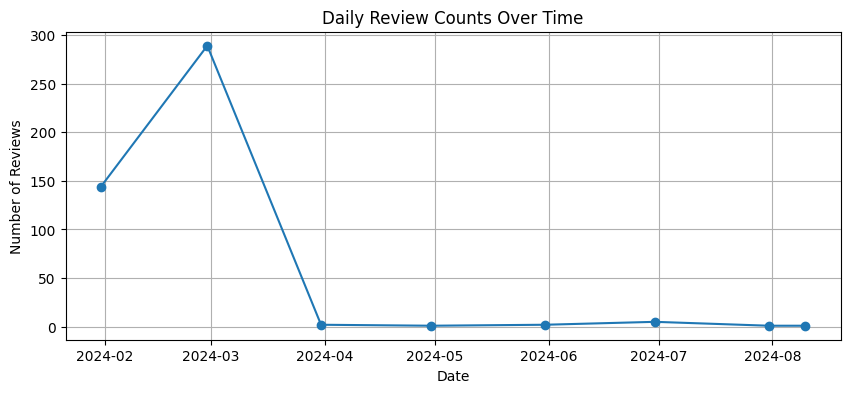

In [40]:
import matplotlib.pyplot as plt  # matplotlib 라이브러리 임포트
# 날짜 데이터를 datetime 객체로 변환
df['date'] = pd.to_datetime(df['date'])

# 날짜별로 데이터를 그룹화하고 리뷰 수를 계산
review_counts = df.groupby(df['date'].dt.date).size()

# 그래프로 시각화
plt.figure(figsize=(10, 4))
review_counts.plot(kind='line', marker='o', linestyle='-')
plt.title('Daily Review Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()


## Huggingface Pipleline 으로 감성 분석

In [41]:
from transformers import pipeline
sentiment_pipeline = pipeline(model="dudcjs2779/sentiment-analysis-with-klue-bert-base")
data = ["너무 좋아요", "조금 아쉬웠어요", "좋은지 나쁜지 모르겠어요", "최악이에요", "최고에요"]
sentiment_pipeline(data)

c:\Users\minns\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\minns\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\minns\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\minns\.cache\huggingface\hub\models--dudcjs2779--sentiment-analysis-with-klue-bert-base. Caching files will still work but in a degraded

[{'label': 'LABEL_1', 'score': 0.9777422547340393},
 {'label': 'LABEL_2', 'score': 0.5432390570640564},
 {'label': 'LABEL_0', 'score': 0.550918459892273},
 {'label': 'LABEL_2', 'score': 0.9763168096542358},
 {'label': 'LABEL_1', 'score': 0.9642011523246765}]

In [42]:
df['comment'].str.len().describe()

count     444.000000
mean       63.144144
std        93.198746
min         3.000000
25%        23.000000
50%        39.000000
75%        65.000000
max      1430.000000
Name: comment, dtype: float64

In [43]:
df[df['comment'].str.len() < 10]

,author,comment,date
235,@user-kn1iq3up9w,광고가 참좋네요,2024-01-31 06:34:22
351,@user-yw3qc3kr1w,좋아요..삼성최고,2024-02-29 06:34:23
361,@user-xf3wn7ml7u,영상잘보았습니다,2024-02-29 06:34:23
381,@sinang1204,좋아요,2024-01-31 06:34:23
383,@user-kr5ne2do7m,기능이 기대되요!,2024-02-29 06:34:23
394,@user-eh1cj6bq3e,진짜 대단하네요,2024-02-29 06:34:23
396,@leech3313,참여하고가용 ^^,2024-01-31 06:34:23
398,@user-tc9lf8co6t,미래 AI시대,2024-01-31 06:34:23
409,@user-gt3tk5ou6h,세상너무좋네여,2024-02-29 06:34:23
413,@user-vt4fv6pq8c,AI가 기대돼요.,2024-01-31 06:34:23


In [44]:
# 리뷰에 대한 감정 분석 결과를 긍정, 부정으로 예측 
def analyze_sentiment_classification(review):
    """
    리뷰에 대한 감정 분석 결과를 중립(LABEL_0), 긍정(LABEL_1), 부정(LABEL_2)로 분류
    Args:
        review: 리뷰 텍스트
    Returns:
        float: 감정 분석 결과
    """
    sentiment_pipeline = pipeline(model="dudcjs2779/sentiment-analysis-with-klue-bert-base")
    sentiment = sentiment_pipeline([str(review)[:100]])[0]
    
    return sentiment['label']

# 함수 실행
sentiment_labels = analyze_sentiment_classification(data[0])
sentiment_labels

c:\Users\minns\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


'LABEL_1'

In [45]:
data[0]

'너무 좋아요'

In [46]:
df['comment'].head()

0     채널 구독 EVENT \r\n\r\nAI의 능력을 모두의 능력으로 만드는 기업 하...
1    삼성SDS의 생성형 AI 서비스가 오피스와 우리의 라이프에 어떤 새바람을 일으킬지\...
2    AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 \r\n삼성S...
3    AI시대 오피스&라이프 오 멋지네요, 삼성 화이팅 노력한데로 이뤄지는 밝은 미래를 ...
4    때와장소를 가리지않는다!딱 맞는표현이네요~!!AI는 어디에든 무궁무진한 기능인것같아...
Name: comment, dtype: object

In [47]:
# HTML 태그 제거
df['comment'] = df['comment'].str.replace('[^A-Za-z0-9가-힣ㄱ-ㅎ\ ]', '', regex=True)
df['comment'].head()

0     채널 구독 EVENT AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 ...
1    삼성SDS의 생성형 AI 서비스가 오피스와 우리의 라이프에 어떤 새바람을 일으킬지너...
2    AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 삼성SDS  ...
3    AI시대 오피스라이프 오 멋지네요 삼성 화이팅 노력한데로 이뤄지는 밝은 미래를 꿈꾸...
4    때와장소를 가리지않는다딱 맞는표현이네요AI는 어디에든 무궁무진한 기능인것같아요삼성S...
Name: comment, dtype: object

In [48]:
# 리뷰에 대한 감정 분석 결과를 데이터프레임에 추가
df['sentiment_class'] = df['comment'].apply(analyze_sentiment_classification)
df.head()

,author,comment,date,sentiment_class
0,@SAMSUNGSDS,채널 구독 EVENT AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 ...,2024-01-31 06:34:22,LABEL_1
1,@user-pw3gk2vn5e,삼성SDS의 생성형 AI 서비스가 오피스와 우리의 라이프에 어떤 새바람을 일으킬지너...,2024-02-29 06:34:22,LABEL_1
2,@user-li3hn3lw6q,AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 삼성SDS ...,2024-02-29 06:34:22,LABEL_1
3,@user-jc6zw1gf9u,AI시대 오피스라이프 오 멋지네요 삼성 화이팅 노력한데로 이뤄지는 밝은 미래를 꿈꾸...,2024-02-29 06:34:22,LABEL_0
4,@humavv,때와장소를 가리지않는다딱 맞는표현이네요AI는 어디에든 무궁무진한 기능인것같아요삼성S...,2024-02-29 06:34:22,LABEL_1


In [50]:
df.to_csv("youtube_reviews_classification.csv", index=False)
df = pd.read_csv("youtube_reviews_classification.csv")
df.head()

,author,comment,date,sentiment_class
0,@SAMSUNGSDS,채널 구독 EVENT AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 ...,2024-01-31 06:34:22,LABEL_1
1,@user-pw3gk2vn5e,삼성SDS의 생성형 AI 서비스가 오피스와 우리의 라이프에 어떤 새바람을 일으킬지너...,2024-02-29 06:34:22,LABEL_1
2,@user-li3hn3lw6q,AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 삼성SDS ...,2024-02-29 06:34:22,LABEL_1
3,@user-jc6zw1gf9u,AI시대 오피스라이프 오 멋지네요 삼성 화이팅 노력한데로 이뤄지는 밝은 미래를 꿈꾸...,2024-02-29 06:34:22,LABEL_0
4,@humavv,때와장소를 가리지않는다딱 맞는표현이네요AI는 어디에든 무궁무진한 기능인것같아요삼성S...,2024-02-29 06:34:22,LABEL_1


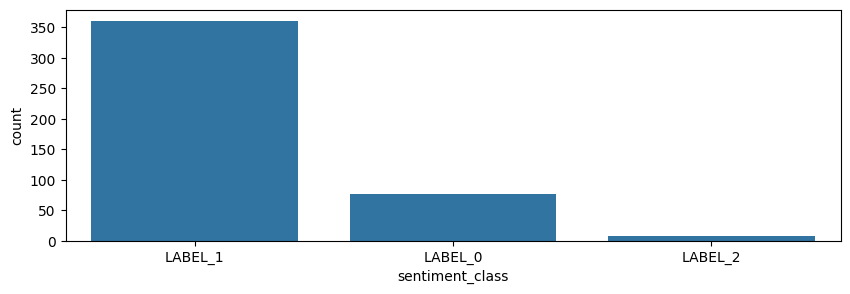

In [52]:
# 감성 분석 결과를 막대 그래프로 비교
import seaborn as sns
plt.figure(figsize=(10, 3))
sns.countplot(x='sentiment_class', data=df)
plt.show()

In [53]:
# 부정 감성을 갖고 있는 데이터를 확인 
df[df['sentiment_class']=="LABEL_2"]

,author,comment,date,sentiment_class
83,@rookiek9754,이래라 저래라 이랬다 저랬다 깜박 꿈뻑 뽜샤 퐈와아아아아브릭스 부뤼튀 귀욥,2024-01-31 06:34:22,LABEL_2
121,@user-oo1kq9hk5m,AI시대가 오고 있네요세상이 너무 빨리 변화되어정신이 없습니다,2024-01-31 06:34:22,LABEL_2
267,@rounlee4873,정교한 필터링으로 정말 너무나 많은 부정확하고 도움 안 되는 인터넷 세상에서 필요한...,2024-02-29 06:34:22,LABEL_2
294,@bumjunyoo1359,오 진짜 이렇게 되나요 그럼 우리 회사도,2024-01-31 06:34:22,LABEL_2
399,@user-ho1qb7sr7j,에이 아이,2024-02-29 06:34:23,LABEL_2
431,@user-rl9ns5qb4o,광고에 나온 해줘 해줘 하는 분들 별로 하는 일 없어보이는데 곧 짤리겠죠 ㅋㅋ,2024-02-29 06:34:23,LABEL_2
442,@sleeping-gypsy,ㅎㅎ 나도 뻔뻔하게 별걸 다물어보고 이래라저래라 이랬다저랬다 해야겠다,2024-02-29 06:34:23,LABEL_2
444,@i8071625,싱기하다,2024-01-31 06:34:23,LABEL_2


C:\Users\minns\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\minns\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48624 (\N{HANGUL SYLLABLE BYU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\minns\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\minns\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\minns\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}

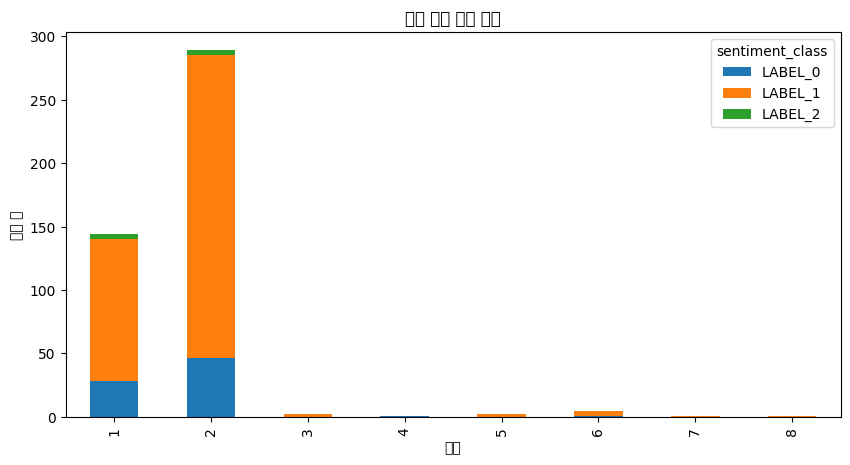

In [54]:
### 시간의 변화에 따른 감성 분석 변화

# 'date' 열을 datetime 형태로 변환
df['date'] = pd.to_datetime(df['date'])

# 월별로 감성 클래스의 빈도 계산
df['month'] = df['date'].dt.month  
grouped_data = df.groupby(['month', 'sentiment_class']).size().reset_index(name='counts')

# Pivot Table 생성
pivot_data = grouped_data.pivot(index='month', columns='sentiment_class', values='counts').fillna(0)

# 시각화
pivot_data.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('월별 감성 분석 결과')
plt.xlabel('날짜')
plt.ylabel('리뷰 수')
plt.show()

## 랭체인을 활용한 LLM 감성분석 (분류)

In [55]:
from langchain_core.prompts.few_shot import FewShotPromptTemplate
from langchain_core.prompts.prompt import PromptTemplate

# 리뷰 예시와 해당 리뷰의 감성(긍정, 부정, 중립)을 정의
examples = [
    {
        "review": "매우 유익했습니다!",
        "sentiment": "긍정",
    },
    {
        "review": "매우 실망스러웠어요.",
        "sentiment": "부정",
    },
    {
        "review": "만족스러웠습니다.",
        "sentiment": "긍정",
    },
    {
        "review": "사용이 간편해서 좋았습니다.",
        "sentiment": "긍정",
    },
    {
        "review": "내용이 조금 지루했지만, 정보는 유용했습니다.",
        "sentiment": "중립",
    },
    {
        "review": "예상보다 참석자가 많아서 질문을 충분히 하지 못했습니다.",
        "sentiment": "부정",
    },
]


# Few-shot 학습을 위한 템플릿 정의
example_prompt = PromptTemplate(
    input_variables=["review", "sentiment"], template="review: {review}\n{sentiment}"
)

print(example_prompt.format(**examples[0]))

review: 매우 유익했습니다!
긍정


In [56]:
prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="review: {input}",
    input_variables=["input"],
)

# 새 리뷰에 대한 감성 분석 예제 생성
new_review = "이벤트 내용은 좋은데 기간이 너무 짧았어요."
print(prompt.format(input=new_review))

review: 매우 유익했습니다!
긍정

review: 매우 실망스러웠어요.
부정

review: 만족스러웠습니다.
긍정

review: 사용이 간편해서 좋았습니다.
긍정

review: 내용이 조금 지루했지만, 정보는 유용했습니다.
중립

review: 예상보다 참석자가 많아서 질문을 충분히 하지 못했습니다.
부정

review: 이벤트 내용은 좋은데 기간이 너무 짧았어요.


In [66]:
# LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125",
                 api_key=OPENAI_API_KEY)

chain = prompt | llm

response = chain.invoke(new_review)

response

AIMessage(content='부정', response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 175, 'total_tokens': 177}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-2b212409-9f0c-4ecf-b9c1-9e2c3556935f-0')

In [67]:
sentiment = response.content
sentiment

'부정'

In [68]:
# 5개의 샘플 데이터
test_df = df.head()
test_df

,author,comment,date,sentiment_class,month
0,@SAMSUNGSDS,채널 구독 EVENT AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 ...,2024-01-31 06:34:22,LABEL_1,1
1,@user-pw3gk2vn5e,삼성SDS의 생성형 AI 서비스가 오피스와 우리의 라이프에 어떤 새바람을 일으킬지너...,2024-02-29 06:34:22,LABEL_1,2
2,@user-li3hn3lw6q,AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 삼성SDS ...,2024-02-29 06:34:22,LABEL_1,2
3,@user-jc6zw1gf9u,AI시대 오피스라이프 오 멋지네요 삼성 화이팅 노력한데로 이뤄지는 밝은 미래를 꿈꾸...,2024-02-29 06:34:22,LABEL_0,2
4,@humavv,때와장소를 가리지않는다딱 맞는표현이네요AI는 어디에든 무궁무진한 기능인것같아요삼성S...,2024-02-29 06:34:22,LABEL_1,2


In [69]:
# 모든 리뷰에 대해서 감성 분석을 적용해서 새로운 열에 추가하는 함수
def analyze_sentiment_llm(review):
    response = chain.invoke(review)
    return response.content

test_df['sentiment_llm'] = test_df['comment'].apply(analyze_sentiment_llm)
test_df

,author,comment,date,sentiment_class,month,sentiment_llm
0,@SAMSUNGSDS,채널 구독 EVENT AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 ...,2024-01-31 06:34:22,LABEL_1,1,홍보성 글이므로 리뷰로 간주되지 않습니다.
1,@user-pw3gk2vn5e,삼성SDS의 생성형 AI 서비스가 오피스와 우리의 라이프에 어떤 새바람을 일으킬지너...,2024-02-29 06:34:22,LABEL_1,2,긍정
2,@user-li3hn3lw6q,AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 삼성SDS ...,2024-02-29 06:34:22,LABEL_1,2,긍정
3,@user-jc6zw1gf9u,AI시대 오피스라이프 오 멋지네요 삼성 화이팅 노력한데로 이뤄지는 밝은 미래를 꿈꾸...,2024-02-29 06:34:22,LABEL_0,2,긍정
4,@humavv,때와장소를 가리지않는다딱 맞는표현이네요AI는 어디에든 무궁무진한 기능인것같아요삼성S...,2024-02-29 06:34:22,LABEL_1,2,긍정


## 랭체인을 활용한 LLM 감성분석 (평점 예측)

In [70]:
from langchain_core.prompts.prompt import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125",
                 api_key=OPENAI_API_KEY)


template = """
Classify the given sentiment of the given text into positive or negative classes and provide a relevant score.
The sentiment score should be between 0.0 and 1.0, where 0.0 indicates a negative sentiment and 1.0 indicates a positive sentiment.

Input: {input}

Output: sentiment_label (Score: sentiment_score)
"""

prompt = PromptTemplate.from_template(template)
output_parser = StrOutputParser()

# LCEL chaining
chain = prompt | llm | output_parser

# chain 호출
response = chain.invoke({"input": "최고예요"})

# 결과 확인
response

'Output: Positive (Score: 1.0)'

In [71]:
re.search(r"\d+\.\d+", response).group()

'1.0'

In [72]:
# 감정 분석 결과를 반환하는 함수 정의
def analyze_sentiment_score_llm(review):
    """
    리뷰에 대한 감정 분석 결과를 0~1 사이의 값으로 변환하는 함수
    Args:
        review: 리뷰 텍스트
    Returns:
        float: 감정 분석 결과
    """
    template = """
    Classify the given sentiment of the given text into positive or negative classes and provide a relevant score.
    The sentiment score should be between 0.0 and 1.0, where 0.0 indicates a negative sentiment and 1.0 indicates a positive sentiment.

    Input: {input}

    Output: sentiment_label (Score: sentiment_score)
    """

    prompt = PromptTemplate.from_template(template)
    output_parser = StrOutputParser()

    llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125",
                     api_key=OPENAI_API_KEY)

    chain = prompt | llm | output_parser

    response = chain.invoke({"input": review})
    
    sentiment_score = re.search(r"\d+\.\d+", response).group()
    
    return sentiment_score


# 함수 실행
sentiment_score = analyze_sentiment_score_llm("최고예요")
sentiment_score

'1.0'

In [73]:
# 함수 실행
sentiment_score = analyze_sentiment_score_llm("별로예요")
sentiment_score

'0.2'

In [74]:
# 함수 실행
sentiment_score = analyze_sentiment_score_llm("보통 수준이에요")
sentiment_score

'0.3'

In [75]:
test_df['sentiment_llm_socre'] = test_df['comment'].apply(analyze_sentiment_score_llm)
test_df

,author,comment,date,sentiment_class,month,sentiment_llm,sentiment_llm_socre
0,@SAMSUNGSDS,채널 구독 EVENT AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 ...,2024-01-31 06:34:22,LABEL_1,1,홍보성 글이므로 리뷰로 간주되지 않습니다.,1.0
1,@user-pw3gk2vn5e,삼성SDS의 생성형 AI 서비스가 오피스와 우리의 라이프에 어떤 새바람을 일으킬지너...,2024-02-29 06:34:22,LABEL_1,2,긍정,0.95
2,@user-li3hn3lw6q,AI의 능력을 모두의 능력으로 만드는 기업 하이퍼오토메이션 엑셀레이터 삼성SDS ...,2024-02-29 06:34:22,LABEL_1,2,긍정,1.0
3,@user-jc6zw1gf9u,AI시대 오피스라이프 오 멋지네요 삼성 화이팅 노력한데로 이뤄지는 밝은 미래를 꿈꾸...,2024-02-29 06:34:22,LABEL_0,2,긍정,0.9
4,@humavv,때와장소를 가리지않는다딱 맞는표현이네요AI는 어디에든 무궁무진한 기능인것같아요삼성S...,2024-02-29 06:34:22,LABEL_1,2,긍정,0.95
